一些想法：
1. 性别差异处理：

男子/女子比赛表现规律不同，建议分开建模

可在数据中添加gender标识列（M/W）做联合训练

2. 避免数据泄漏

严格按赛季分割训练/验证集（如用2015-2023训练，2024验证）

常规赛数据仅用于计算历史表现，不与对应年份的锦标赛数据混合

3. 预测单场比赛胜负（分类问题）

使用XGBoost等算法，输入特征包含：

种子差异

Elo评分差异

常规赛进攻效率对比

历史交锋记录（如有


4. 潜在风险：

未验证各文件列结构一致性（建议增加assert list(df1.columns) == list(df2.columns)）

未处理 2020 年数据缺失（需过滤Season==2020）

5. 六、扩展方向
高阶特征：

计算每队的滚动平均得分（使用groupby+expanding）

添加种子排名差异特征

模型适配：

对类别特征（如T1_TeamID）进行编码

标准化数值特征（如得分、篮板等）

In [1]:
from numpy.linalg import LinAlgError  # 新增此行
import statsmodels.api as sm



In [2]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import brier_score_loss

pd.set_option("display.max_column", 999)
print(os.listdir("../input"))

['march-machine-learning-mania-2025']


# Load the data!

In [3]:
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2025/'

# Data preparation!

In [4]:
tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [5]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)
all(regular_results.columns == tourney_results.columns)

True

In [6]:
regular_data.shape

(401180, 35)

In [7]:
tourney_data.shape

(4552, 35)

In [8]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [9]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


# Feature engineering!

In [10]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [11]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]
funcs2 = [np.mean, np.std]

**扩
展性：funcs 可同时指定多个函数（例如[np.mean, np.max]）**

In [12]:

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()


,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [13]:
"""
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs2).reset_index()
season_statistics.head()
"""

'\nseason_statistics = regular_data.groupby(["Season", \'T1_TeamID\'])[boxscore_cols].agg(funcs2).reset_index()\nseason_statistics.head()\n'

In [14]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [15]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [16]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [17]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [18]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


In [19]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [20]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [21]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [22]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [23]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [24]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(21652, 5)

In [25]:
regular_season_effects.tail()

,Season,T1_TeamID,T2_TeamID,PointDiff,win
21647,2025,3199,3181,-14,0
21648,2025,3228,3276,-9,0
21649,2025,3261,3279,-8,0
21650,2025,3104,3328,-7,0
21651,2025,3246,3376,-12,0


In [26]:
def team_quality(season):
    try:
        formula = 'win~-1+T1_TeamID+T2_TeamID'
        glm = sm.GLM.from_formula(formula=formula, 
                                  data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                                  family=sm.families.Binomial()).fit()
        
        quality = pd.DataFrame(glm.params).reset_index()
        quality.columns = ['TeamID','quality']
        quality['Season'] = season
        #quality['quality'] = np.exp(quality['quality'])
        quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
        quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
        return quality

    except LinAlgError as e:
        print(f"赛季 {season} 建模失败：矩阵奇异或不可逆（{str(e)}）")
    except ValueError as e:
        print(f"赛季 {season} 建模失败：数据格式错误（{str(e)}）")
    except Exception as e:
        print(f"赛季 {season} 建模失败：未知错误（{str(e)}）")

In [27]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         #team_quality(2024),
                         team_quality(2025)
                         ]).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


In [28]:
glm_quality.head(20)

,TeamID,quality,Season
0,1115,4.369391e+14,2010
1,1124,6.284811e+15,2010
2,1139,6.678640e+15,2010
3,1140,5.926456e+15,2010
4,1143,5.356252e+15,2010
5,1155,6.693760e+15,2010
6,1165,-1.189917e+16,2010
7,1181,7.318165e+15,2010
8,1190,-8.786761e+15,2010
9,1196,5.168589e+15,2010


In [29]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [30]:
glm_quality_T2.head()

,T2_TeamID,T2_quality,Season
0,1115,4.369391e+14,2010
1,1124,6.284811e+15,2010
2,1139,6.678640e+15,2010
3,1140,5.926456e+15,2010
4,1143,5.356252e+15,2010


In [31]:
glm_quality_T1.head()


,T1_TeamID,T1_quality,Season
0,1115,4.369391e+14,2010
1,1124,6.284811e+15,2010
2,1139,6.678640e+15,2010
3,1140,5.926456e+15,2010
4,1143,5.356252e+15,2010


In [32]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [33]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN


In [34]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [35]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.tail()

,Season,Seed,TeamID,seed
4365,2025,Z12,3193,12
4366,2025,Z13,3251,13
4367,2025,Z14,3195,14
4368,2025,Z15,3117,15
4369,2025,Z16,3422,16


In [36]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [37]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [38]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

In [39]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4552.000000
mean        0.000000
std        17.479045
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [40]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [41]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [42]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN,8,9,-1


In [43]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [44]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.02, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [45]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 20,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.5722+0.0579248	test-mae:13.5741+0.239919
[50]	train-mae:10.4318+0.0421242	test-mae:10.5443+0.212768
[100]	train-mae:9.64309+0.0387605	test-mae:9.85441+0.172782
[150]	train-mae:9.36046+0.0387152	test-mae:9.66717+0.171977
[200]	train-mae:9.20635+0.0382379	test-mae:9.59875+0.173375
[250]	train-mae:9.09043+0.0380983	test-mae:9.56674+0.171738
[300]	train-mae:8.98734+0.039158	test-mae:9.55009+0.169408
[350]	train-mae:8.89501+0.0396087	test-mae:9.54236+0.168626
[400]	train-mae:8.80841+0.0409645	test-mae:9.53694+0.167317
[450]	train-mae:8.72587+0.040194	test-mae:9.53356+0.167526
[500]	train-mae:8.64644+0.0401749	test-mae:9.53151+0.166009
Fold repeater 1
[0]	train-mae:13.5732+0.0758337	test-mae:13.575+0.308992
[50]	train-mae:10.4298+0.0518546	test-mae:10.544+0.211526
[100]	train-mae:9.63879+0.0493042	test-mae:9.84859+0.198593
[150]	train-mae:9.35694+0.0506087	test-mae:9.66072+0.207224
[200]	train-mae:9.20194+0.04898	test-mae:9.59608+0.219892
[250]	train-mae:9.08

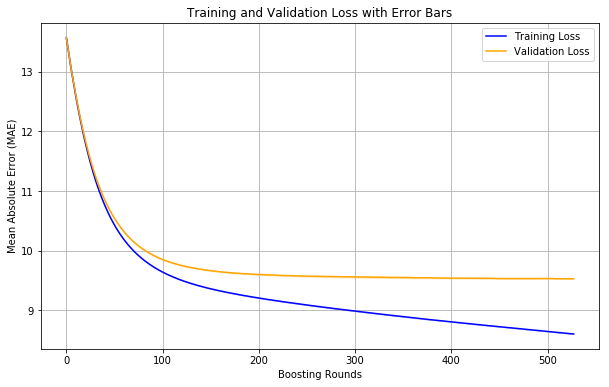

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 xgb_cv 已经通过交叉验证生成
train_loss_history = []
val_loss_history = []

# 提取训练和验证损失
for cv_result in xgb_cv:
    train_loss_history.append(cv_result['train-mae-mean'].values)
    val_loss_history.append(cv_result['test-mae-mean'].values)

# 找到最大迭代次数
max_length = max(len(loss) for loss in train_loss_history)

# 填充到相同长度
train_loss_history_aligned = np.array([
    np.pad(loss, (0, max_length - len(loss)), mode='constant', constant_values=np.nan)
    for loss in train_loss_history
])
val_loss_history_aligned = np.array([
    np.pad(loss, (0, max_length - len(loss)), mode='constant', constant_values=np.nan)
    for loss in val_loss_history
])

# 计算均值和标准差（忽略 NaN）
train_loss_mean = np.nanmean(train_loss_history_aligned, axis=0)
train_loss_std = np.nanstd(train_loss_history_aligned, axis=0)
val_loss_mean = np.nanmean(val_loss_history_aligned, axis=0)
val_loss_std = np.nanstd(val_loss_history_aligned, axis=0)

# 绘制损失曲线
plt.figure(figsize=(10, 6))

# 绘制训练损失曲线及误差范围
plt.plot(train_loss_mean, label='Training Loss', color='blue')
plt.fill_between(range(len(train_loss_mean)), 
                 train_loss_mean - train_loss_std, 
                 train_loss_mean + train_loss_std, 
                 color='blue', alpha=0.2)

# 绘制验证损失曲线及误差范围
plt.plot(val_loss_mean, label='Validation Loss', color='orange')
plt.fill_between(range(len(val_loss_mean)), 
                 val_loss_mean - val_loss_std, 
                 val_loss_mean + val_loss_std, 
                 color='orange', alpha=0.2)

# 添加标签和图例
plt.xlabel('Boosting Rounds')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation Loss with Error Bars')
plt.legend()
plt.grid()
plt.show()


In [47]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

#
([163, 219, 185], [9.547729200000001, 9.535706999999999, 9.5347692])

([163, 219, 185], [9.547729200000001, 9.535706999999999, 9.5347692])

In [48]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              

              dtrain= dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


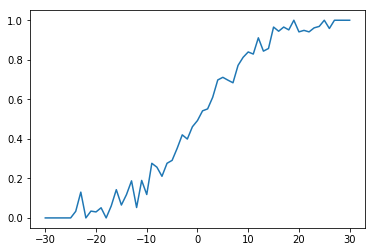

In [49]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

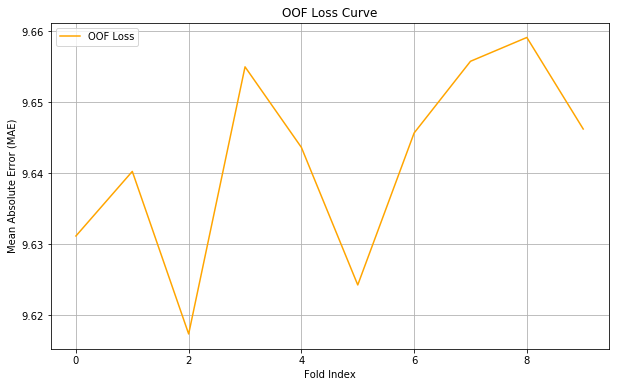

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 oof_preds 是 OOF 预测结果，y 是真实标签
oof_losses = []
for i in range(len(oof_preds)):
    oof_loss = np.mean(np.abs(y - oof_preds[i]))
    oof_losses.append(oof_loss)


# 绘制对比曲线
plt.figure(figsize=(10, 6))
plt.plot(oof_losses, label='OOF Loss', color='orange')
plt.xlabel('Fold Index')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('OOF Loss Curve')
plt.legend()
plt.grid()
plt.show()


In [51]:
spline_model = []

"""from collections import defaultdict
temp_dict = defaultdict(list)
for pred, label in dat:
    temp_dict[pred].append(label)
dat_agg = {k: np.mean(v) for k, v in temp_dict.items()}
"""
for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit, 0.01, 0.99)

    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5126645962272347
logloss of cvsplit 1: 0.5135620915676218
logloss of cvsplit 2: 0.5120965005071212
logloss of cvsplit 3: 0.5142549492464314
logloss of cvsplit 4: 0.5123460114149124
logloss of cvsplit 5: 0.5140162724694105
logloss of cvsplit 6: 0.513620354694145
logloss of cvsplit 7: 0.5139668448527008
logloss of cvsplit 8: 0.5134537729162348
logloss of cvsplit 9: 0.5140533494762735


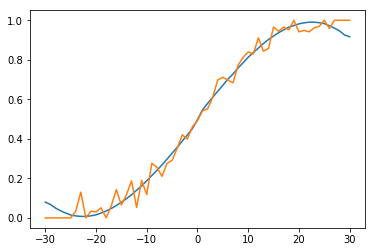

In [52]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [53]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.04507200203797
adjusted logloss of cvsplit 1: 1.0459356282398942
adjusted logloss of cvsplit 2: 1.044908738182833
adjusted logloss of cvsplit 3: 1.0466346538580682
adjusted logloss of cvsplit 4: 1.0457348294175182
adjusted logloss of cvsplit 5: 1.046492805223884
adjusted logloss of cvsplit 6: 1.0465846500101383
adjusted logloss of cvsplit 7: 1.0460443598071294
adjusted logloss of cvsplit 8: 1.0452466889070284
adjusted logloss of cvsplit 9: 1.0467905117712515


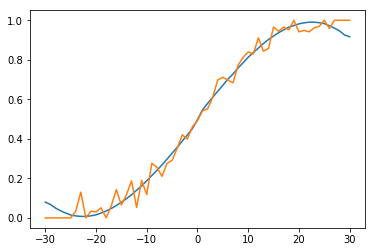

In [54]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [55]:
from sklearn.metrics import brier_score_loss

val_cv = []
spline_model = []
brier_scores = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i], np.where(y > 0, 1, 0)))
    dat = sorted(dat, key=lambda x: x[0])
    
    # 聚合相同预测值的标签均值（修复覆盖问题）
    from collections import defaultdict
    temp_dict = defaultdict(list)
    for pred, label in dat:
        temp_dict[pred].append(label)
    dat_agg = {k: np.mean(v) for k, v in temp_dict.items()}
    sorted_preds = sorted(dat_agg.keys())
    sorted_labels = [dat_agg[k] for k in sorted_preds]
    
    # 拟合样条模型并校准预测概率
    spline = UnivariateSpline(sorted_preds, sorted_labels)
    spline_model.append(spline)
    spline_fit = spline(oof_preds[i])
    spline_fit = np.clip(spline_fit, 0.025, 0.975)
    
    
    spline_fit[(tourney_data.T1_seed == 1) & (tourney_data.T2_seed == 16)] = 1.0
    spline_fit[(tourney_data.T1_seed == 2) & (tourney_data.T2_seed == 15)] = 1.0
    spline_fit[(tourney_data.T1_seed == 3) & (tourney_data.T2_seed == 14)] = 1.0
    spline_fit[(tourney_data.T1_seed == 14) & (tourney_data.T2_seed == 3)] = 1.0
    spline_fit[(tourney_data.T1_seed == 16) & (tourney_data.T2_seed == 1)] = 0.0
    spline_fit[(tourney_data.T1_seed == 15) & (tourney_data.T2_seed == 2)] = 0.0

    
    # 记录结果并计算指标
    val_cv.append(pd.DataFrame({
        "y": np.where(y > 0, 1, 0),
        "pred": spline_fit,
        "season": tourney_data.Season
    }))
    
    # 计算对数损失和 Brier Score
    current_logloss = log_loss(np.where(y > 0, 1, 0), spline_fit)
    current_brier = brier_score_loss(np.where(y > 0, 1, 0), spline_fit)
    brier_scores.append(current_brier)
    print(f"CV {i} | Log Loss: {current_logloss:.4f} | Brier Score: {current_brier:.4f}")

# 按赛季输出平均 Brier Score
val_cv = pd.concat(val_cv)
seasonal_brier = val_cv.groupby('season').apply(
    lambda x: brier_score_loss(x.y, x.pred)
)
print("\n按赛季的 Brier Score:")
print(seasonal_brier)

# 输出整体平均 Brier Score
print(f"\n平均 Brier Score: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}")


CV 0 | Log Loss: 1.6771 | Brier Score: 0.1990
CV 1 | Log Loss: 1.6781 | Brier Score: 0.1993
CV 2 | Log Loss: 1.6768 | Brier Score: 0.1989
CV 3 | Log Loss: 1.6786 | Brier Score: 0.1995
CV 4 | Log Loss: 1.6779 | Brier Score: 0.1994
CV 5 | Log Loss: 1.6790 | Brier Score: 0.1996
CV 6 | Log Loss: 1.6784 | Brier Score: 0.1994
CV 7 | Log Loss: 1.6779 | Brier Score: 0.1994
CV 8 | Log Loss: 1.6771 | Brier Score: 0.1989
CV 9 | Log Loss: 1.6789 | Brier Score: 0.1995

按赛季的 Brier Score:
season
2003    0.217446
2004    0.205457
2005    0.190150
2006    0.217438
2007    0.176524
2008    0.191339
2009    0.192038
2010    0.192169
2011    0.204837
2012    0.198942
2013    0.201232
2014    0.198492
2015    0.164829
2016    0.211545
2017    0.193684
2018    0.216034
2019    0.183075
2021    0.211101
2022    0.217858
2023    0.211699
2024    0.186303
dtype: float64

平均 Brier Score: 0.1993 ± 0.0003


In [56]:
from sklearn.metrics import brier_score_loss

val_cv = []
spline_model = []
brier_scores = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i], np.where(y > 0, 1, 0)))
    dat = sorted(dat, key=lambda x: x[0])
    
    # 聚合相同预测值的标签均值（修复覆盖问题）
    from collections import defaultdict
    temp_dict = defaultdict(list)
    for pred, label in dat:
        temp_dict[pred].append(label)
    dat_agg = {k: np.mean(v) for k, v in temp_dict.items()}
    sorted_preds = sorted(dat_agg.keys())
    sorted_labels = [dat_agg[k] for k in sorted_preds]
    
    # 拟合样条模型并校准预测概率
    spline = UnivariateSpline(sorted_preds, sorted_labels)
    spline_model.append(spline)
    spline_fit = spline(oof_preds[i])
    spline_fit = np.clip(spline_fit, 0.025, 0.975)
    
    """# 基于种子排名的后处理调整
    spline_fit[(tourney_data.T1_seed == 1) & (tourney_data.T2_seed == 16)] = 1.0
    spline_fit[(tourney_data.T1_seed == 2) & (tourney_data.T2_seed == 15)] = 1.0
    spline_fit[(tourney_data.T1_seed == 3) & (tourney_data.T2_seed == 14)] = 1.0
    spline_fit[(tourney_data.T1_seed == 14) & (tourney_data.T2_seed == 3)] = 1.0
    spline_fit[(tourney_data.T1_seed == 16) & (tourney_data.T2_seed == 1)] = 0.0
    spline_fit[(tourney_data.T1_seed == 15) & (tourney_data.T2_seed == 2)] = 0.0
    """
    
    # 记录结果并计算指标
    val_cv.append(pd.DataFrame({
        "y": np.where(y > 0, 1, 0),
        "pred": spline_fit,
        "season": tourney_data.Season
    }))
    
    # 计算对数损失和 Brier Score
    current_logloss = log_loss(np.where(y > 0, 1, 0), spline_fit)
    current_brier = brier_score_loss(np.where(y > 0, 1, 0), spline_fit)
    brier_scores.append(current_brier)
    print(f"CV {i} | Log Loss: {current_logloss:.4f} | Brier Score: {current_brier:.4f}")

# 按赛季输出平均 Brier Score
val_cv = pd.concat(val_cv)
seasonal_brier = val_cv.groupby('season').apply(
    lambda x: brier_score_loss(x.y, x.pred)
)
print("\n按赛季的 Brier Score:")
print(seasonal_brier)

# 输出整体平均 Brier Score
print(f"\n平均 Brier Score: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}")


CV 0 | Log Loss: 0.5115 | Brier Score: 0.1722
CV 1 | Log Loss: 0.5127 | Brier Score: 0.1726
CV 2 | Log Loss: 0.5109 | Brier Score: 0.1721
CV 3 | Log Loss: 0.5130 | Brier Score: 0.1728
CV 4 | Log Loss: 0.5114 | Brier Score: 0.1725
CV 5 | Log Loss: 0.5130 | Brier Score: 0.1728
CV 6 | Log Loss: 0.5127 | Brier Score: 0.1726
CV 7 | Log Loss: 0.5125 | Brier Score: 0.1726
CV 8 | Log Loss: 0.5114 | Brier Score: 0.1721
CV 9 | Log Loss: 0.5130 | Brier Score: 0.1726

按赛季的 Brier Score:
season
2003    0.187024
2004    0.174974
2005    0.173140
2006    0.199683
2007    0.146046
2008    0.161217
2009    0.162190
2010    0.167499
2011    0.174846
2012    0.167368
2013    0.176809
2014    0.174404
2015    0.146756
2016    0.187656
2017    0.163841
2018    0.185754
2019    0.153508
2021    0.184871
2022    0.188437
2023    0.180835
2024    0.163119
dtype: float64

平均 Brier Score: 0.1725 ± 0.0003


In [57]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3290,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,1.229404e+15,-2.877398e+15,1,16,-15
3547,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,1.000000,0.666667,5.860930e+14,-2.250059e+16,1,16,-15
2881,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,1.992558e+15,-2.310647e+15,2,15,-13
2884,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,2.639178e+15,-3.116482e+15,2,15,-13
2944,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,5.599960e+14,-3.209018e+13,2,15,-13
3146,2016,137,1277,81,1292,90,28.794118,59.529412,9.117647,21.029412,12.294118,20.558824,11.794118,4.411765,19.088235,21.794118,57.823529,5.676471,18.794118,9.352941,10.617647,9.558824,5.323529,3.235294,16.382353,25.903226,57.709677,8.000000,20.580645,10.258065,13.032258,11.935484,6.258065,20.451613,23.225806,54.322581,6.258065,18.354839,9.064516,11.451613,13.516129,5.838710,2.774194,4.096774,1.000000,1.000000,-2.995853e+14,-1.764228e+15,2,15,-13
3403,2021,137,1326,72,1331,75,26.333333,57.300000,8.233333,22.566667,8.333333,13.033333,9.933333,4.600000,18.466667,24.733333,58.366667,7.566667,22.166667,8.133333,13.600000,9.900000,4.633333,2.700000,6.366667,27.260870,61.000000,10.869565,28.000000,6.565217,11.608696,11.173913,6.217391,17.869565,27.956522,62.565217,7.130435,20.043478,10.347826,12.391304,12.478261,5.565217,3.086957,1.826087,0.600000,1.000000,1.736001e+15,-9.300608e+14,2,15,-13
3474,2022,136,1246,79,1389,85,30.424242,62.787879,6.151515,17.606061,11.393939,16.090909,11.121212,6.818182,14.242424,24.424

# Submission time!

In [58]:

sub = pd.read_csv(DATA_PATH + "SampleSubmissionStage2.csv")
#sub = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104
3,2025_1101_1105,0.5,2025,1101,1105
4,2025_1101_1106,0.5,2025,1101,1106


In [59]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2025_1101_1102,0.5,2025,1101,1102,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,21.250000,50.500000,8.093750,24.468750,5.937500,13.375000,12.187500,5.656250,17.843750,26.406250,54.937500,7.218750,19.906250,7.937500,12.843750,9.687500,6.812500,3.218750,-11.718750,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
1,2025_1101_1103,0.5,2025,1101,1103,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,30.218750,64.125000,10.656250,29.093750,9.968750,17.687500,11.750000,7.562500,18.281250,26.687500,61.375000,7.437500,23.343750,8.843750,11.937500,12.000000,7.187500,2.437500,8.062500,NaN,2.849000e+14,NaN,13.0,0.333333,1.0,NaN
2,2025_1101_1104,0.5,2025,1101,1104,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,31.090909,64.424242,10.424242,29.787879,10.969697,16.787879,12.121212,6.060606,19.030303,28.909091,68.090909,7.363636,23.909091,10.333333,12.666667,10.060606,7.818182,4.242424,9.696970,NaN,1.221569e+16,NaN,2.0,0.333333,0.5,NaN
3,2025_1101_1105,0.5,2025,1101,1105,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,23.137931,59.793103,7.655172,24.862069,11.344828,12.344828,15.103448,8.000000,21.310345,26.551724,56.517241,8.275862,21.206897,9.724138,15.344828,14.137931,9.068966,3.034483,-10.586207,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
4,2025_1101_1106,0.5,2025,1101,1106,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,25.121212,62.787879,8.848485,26.909091,9.333333,11.393939,8.727273,7.636364,18.212121,24.818182,56.757576,7.484848,22.393939,9.151515,12.484848,12.060606,5.242424,3.272727,-0.303030,NaN,-9.027792e+14,NaN,16.0,0.333333,1.0,NaN


In [60]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [61]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [62]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [63]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2025_1101_1102,0.841671,2025,1101,1102,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,21.250000,50.500000,8.093750,24.468750,5.937500,13.375000,12.187500,5.656250,17.843750,26.406250,54.937500,7.218750,19.906250,7.937500,12.843750,9.687500,6.812500,3.218750,-11.718750,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
1,2025_1101_1103,0.900177,2025,1101,1103,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,30.218750,64.125000,10.656250,29.093750,9.968750,17.687500,11.750000,7.562500,18.281250,26.687500,61.375000,7.437500,23.343750,8.843750,11.937500,12.000000,7.187500,2.437500,8.062500,NaN,2.849000e+14,NaN,13.0,0.333333,1.0,NaN
2,2025_1101_1104,0.795862,2025,1101,1104,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,31.090909,64.424242,10.424242,29.787879,10.969697,16.787879,12.121212,6.060606,19.030303,28.909091,68.090909,7.363636,23.909091,10.333333,12.666667,10.060606,7.818182,4.242424,9.696970,NaN,1.221569e+16,NaN,2.0,0.333333,0.5,NaN
3,2025_1101_1105,0.893264,2025,1101,1105,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,23.137931,59.793103,7.655172,24.862069,11.344828,12.344828,15.103448,8.000000,21.310345,26.551724,56.517241,8.275862,21.206897,9.724138,15.344828,14.137931,9.068966,3.034483,-10.586207,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
4,2025_1101_1106,0.931394,2025,1101,1106,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,25.121212,62.787879,8.848485,26.909091,9.333333,11.393939,8.727273,7.636364,18.212121,24.818182,56.757576,7.484848,22.393939,9.151515,12.484848,12.060606,5.242424,3.272727,-0.303030,NaN,-9.027792e+14,NaN,16.0,0.333333,1.0,NaN


In [64]:
sub.tail()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
131402,2025_3477_3479,0.903715,2025,3477,3479,22.481481,59.666667,7.074074,21.925926,6.962963,13.074074,15.259259,6.259259,17.296296,26.925926,63.296296,5.888889,18.777778,11.37037,14.444444,13.074074,8.185185,3.037037,-11.296296,21.5,52.791667,6.666667,20.916667,5.291667,10.458333,17.791667,5.666667,18.708333,26.375000,58.750000,4.791667,16.208333,8.375,12.375000,15.333333,8.875000,2.375000,-7.708333,NaN,NaN,NaN,NaN,0.000000,0.0,NaN
131403,2025_3477_3480,0.813299,2025,3477,3480,22.481481,59.666667,7.074074,21.925926,6.962963,13.074074,15.259259,6.259259,17.296296,26.925926,63.296296,5.888889,18.777778,11.37037,14.444444,13.074074,8.185185,3.037037,-11.296296,23.5,58.571429,5.857143,20.892857,10.392857,12.642857,16.785714,7.321429,17.357143,26.142857,60.321429,5.678571,19.000000,9.750,12.964286,14.392857,7.678571,3.035714,-5.285714,NaN,NaN,NaN,NaN,0.000000,0.0,NaN
131404,2025_3478_3479,0.895420,2025,3478,3479,18.129032,51.387097,6.322581,20.193548,7.290323,9.741935,15.838710,5.258065,13.709677,26.193548,60.032258,8.548387,24.677419,9.83871,16.580645,11.870968,7.806452,2.548387,-15.096774,21.5,52.791667,6.666667,20.916667,5.291667,10.458333,17.791667,5.666667,18.708333,26.375000,58.750000,4.791667,16.208333,8.375,12.375000,15.333333,8.875000,2.375000,-7.708333,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
131405,2025_3478_3480,0.798529,2025,3478,3480,18.129032,51.387097,6.322581,20.193548,7.290323,9.741935,15.838710,5.258065,13.709677,26.193548,60.032258,8.548387,24.677419,9.83871,16.580645,11.870968,7.806452,2.548387,-15.096774,23.5,58.571429,5.857143,20.892857,10.392857,12.642857,16.785714,7.321429,17.357143,26.142857,60.321429,5.678571,19.000000,9.750,12.964286,14.392857,7.678571,3.035714,-5.285714,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
131406,2025_3479_3480,0.790473,2025,3479,3480,21.500000,52.791667,6.666667,20.916667,5.291667,10.458333,17.791667,5.666667,18.708333,26.375000,58.750000,4.791667,16.208333,8.37500,12.375000,15.333333,8.875000,2.375000,-7.708333,23.5,58.571429,5.857143,20.892857,10.392857,12.642857,16.785714,7.321429,17.357143,26.142857,60.321429,5.678571,19.000000,9.750,12.964286,14.392857,7.678571,3.035714,-5.285714,NaN,NaN,NaN,NaN,0.000000,0.0,NaN
